한글 설정

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
plt.rc('font', family='NanumGothicCoding')

In [3]:
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

In [4]:
# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# 4.1 선형 회귀


[참고](https://github.com/rickiepark/handson-ml2/blob/master/04_training_linear_models.ipynb)

## 4.1.1 정규방정식

In [5]:
import numpy as np

X = 2*np.random.rand(100,1)
y = 4 + 3*X + np.random.randn(100,1)

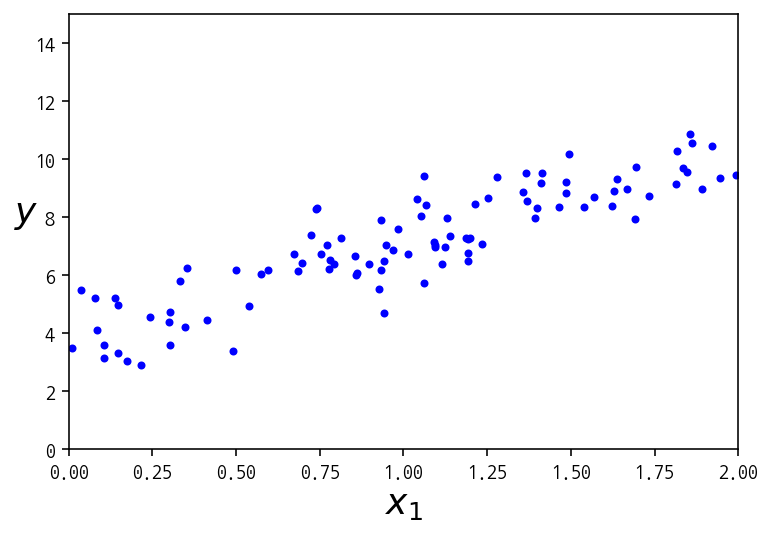

In [6]:
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.show()

무작위로 생성한 선형 데이터셋

In [7]:
#숫자는 남기고 shape은 살리기 위해 모든 샘플에 x0=1을 추가(design matrix 참고)
X_b = np.c_[np.ones( (100,1) ), X] #np.c_ : column stack
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) 
#np.linalg : linear algebra, inv() : inverse matrix, dot() : dot product

In [8]:
print(theta_best)

[[3.83371507]
 [3.23808231]]


의도한 바는 4와 3이었는데 잡음 때문에 정확하게 예측하지 못함.

In [9]:
#theta hat을 이용하여 예측

X_new = np.array([ [0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new] #모든 샘플에 x0=1을 추가
y_predict =  X_new_b.dot(theta_best)
y_predict

array([[ 3.83371507],
       [10.30987969]])

<function matplotlib.pyplot.show(close=None, block=None)>

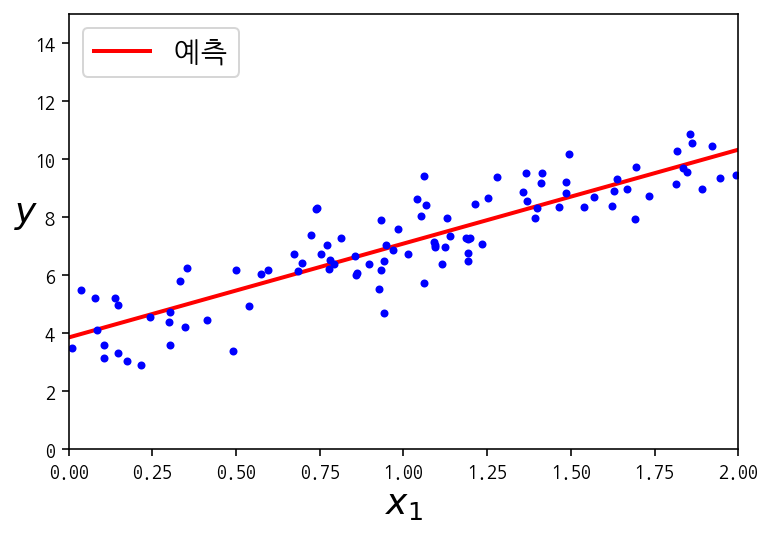

In [10]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="예측")
plt.plot(X, y, "b.")
plt.axis([0,2,0,15])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show

In [11]:
#사이킷런에서 선형 회귀하기
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.83371507]), array([[3.23808231]]))

In [12]:
lin_reg.predict(X_new)

array([[ 3.83371507],
       [10.30987969]])

Linear Regression 클래스는 scipy.linalg.lstsq() 함수(least square)를 기반으로 함.

In [13]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6) #rcond : 작은 특이값에 대한 차단 비율
theta_best_svd #svd : singular value decomposition

array([[3.83371507],
       [3.23808231]])

$ 
\bf{\hat{\bf{\theta}} } = \bf{X}^+ \bf{y}
$
를 계산. $ \bf {X}^+  $ 는 유사역행렬(pseudo inverse, Moore-Penrose inverse).

In [14]:
np.linalg.pinv(X_b).dot(y)

array([[3.83371507],
       [3.23808231]])

# 4.2 경사 하강법
## 4.2.1 배치 경사 하강법

In [15]:
eta = 0.1 #learning rate
n_iterations = 1000 #iteration : 되풀이
m = 100

theta = np.random.randn(2,1) #무작위 초기화

for iteration in range(n_iterations) :
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradients

print(theta)

[[3.83371507]
 [3.23808231]]


In [16]:
theta_path_bgd = [] #?????

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

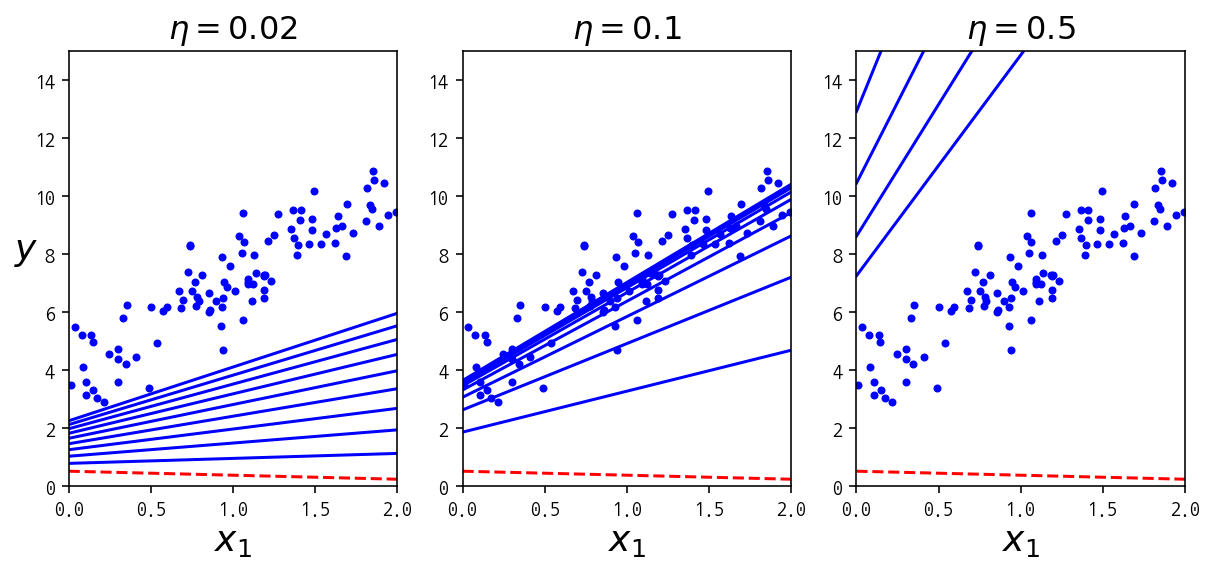

In [17]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

빨간 점선부터 시작해서 파란 점들로 가고 싶은 것임.

왼쪽은 너무 느리고, 오른쪽은 너무 커서 발산해버림. 가운데가 가장 적절.

## 4.2.2 확률적 경사 하강법

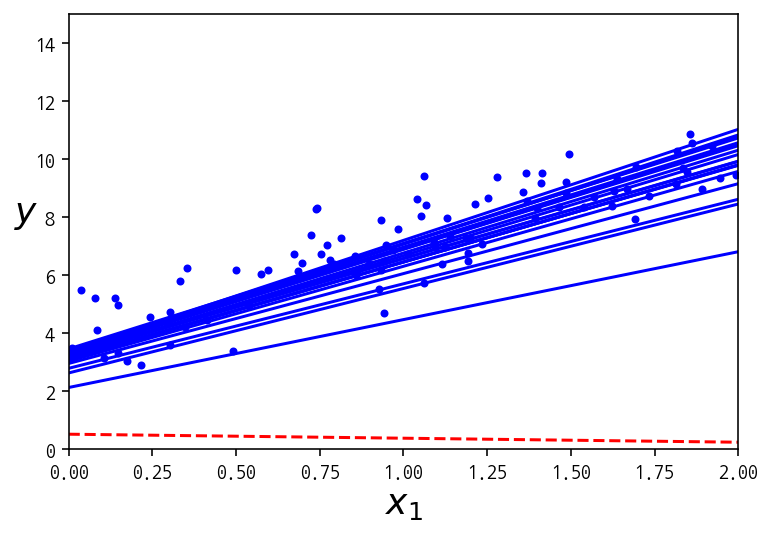

In [18]:
n_epochs = 50
t0, t1 = 5, 50 #learning schedule parameter

def learning_schedule(t) :
    return t0/(t + t1)

theta = np.random.randn(2,1) #무작위 초기화

theta_path_sgd = []

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization


for epoch in range(n_epochs) :
    for i in range(m) : 
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index +1]
        yi = y[random_index : random_index +1]
        gradients = 2*xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch*m + i)
        theta = theta - eta*gradients
        theta_path_sgd.append(theta) 
        
plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                                
plt.show()                

In [19]:
theta

array([[3.83827619],
       [3.25901583]])

In [20]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [21]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.76741273]), array([3.16593333]))

# 4.3 다항 회귀

In [22]:
m = 100
X = 6*np.random.rand(m, 1) - 3
y = 0.5*X**2 + X + 2 + np.random.randn(m, 1)

In [23]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([1.97322766])

In [24]:
X_poly[0]

array([1.97322766, 3.89362739])

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.19573036]), array([[1.00978737, 0.4681429 ]]))

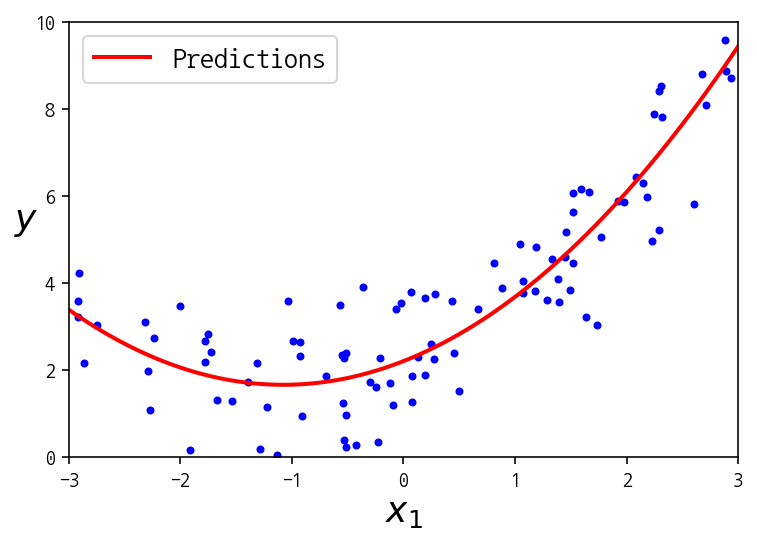

In [26]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10]) 
plt.show() 

# 4.4 학습 곡선

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y) :
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)) :
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")
    plt.legend(loc="upper right", fontsize=14) 

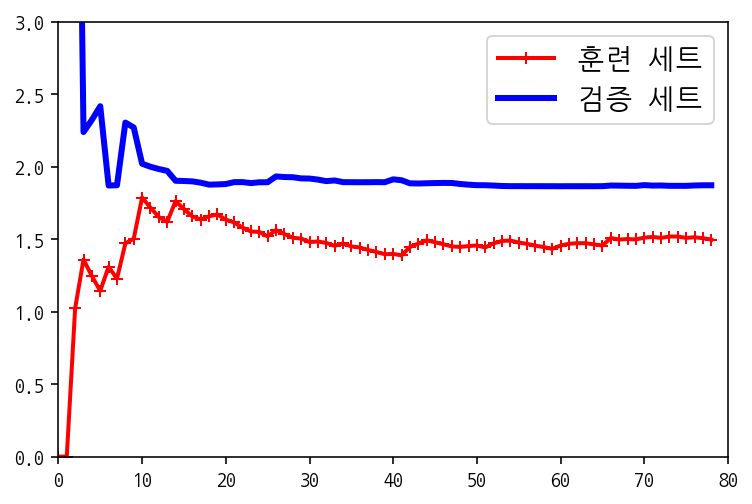

In [28]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

과소적합 모델의 전형적인 모습.

두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해있음.

과소적합일 때는 훈련 샘플을 더 추가해도 효과가 없음. 복잡한 모델을 사용하거나 나은 특성을 선택해야 함.

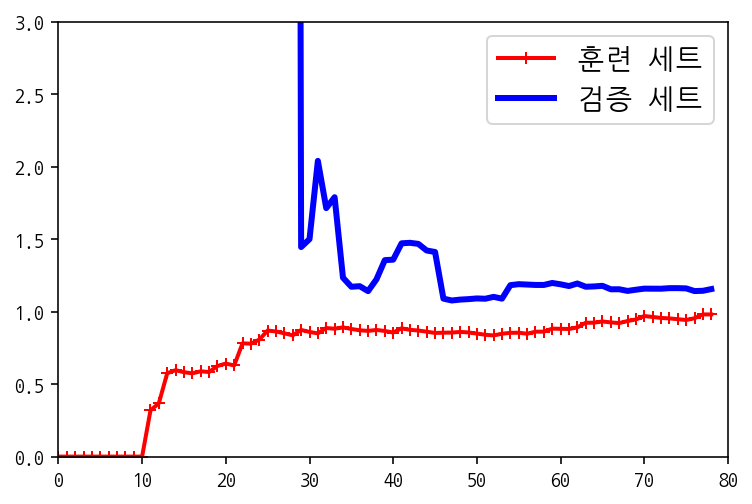

In [29]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

- 선형 회귀 모델보다 훈련 데이터의 오차가 낮다.
- 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다. (과대적합 모델의 특징)
- 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐. (검증 데이터의 성능이 좋아진다는 뜻)

# 4.5 규제가 있는 선형 모델

## 4.5.1 릿지 회귀

릿지(ridge) 회귀(티호노프(Tikhonov) 규제) : 규제가 추가된 선형 회귀 버전

릿지 회귀의 비용함수 : $ J( \bf{ \theta } ) = \text{MSE} ( \bf{ \theta } ) + \alpha \frac{1}{2} \sum _{i=1} ^n \theta _i ^2 $

In [30]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.02702991]])

## 4.5.2 라쏘 회귀

$ J ( \bf{ \theta } ) = \text{MSE} ( \bf{ \theta } ) + \alpha \sum_{i=1} ^n | \theta_i | $

특징 : 덜 중요한 특성의 가중치를 제거한다.

In [31]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.98116023])

## 4.5.3 엘라스틱넷

릿지와 라쏘 회귀를 절충한 모델

$$ J( \theta ) = \text{MSE} ( \theta ) + r \alpha \sum_{i=1} ^n | \theta _i | + \frac{1-r}{2} \alpha \sum_{i=1} ^n \theta_i ^2 $$

 - 릿지가 기본
 - 쓰이는 특성이 적다 : 라쏘
 - 특성 수가 많거나 몇 개가 강하게 연결 : 엘라스틱넷

In [32]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) #l1_ratio : 혼합 비율
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.97950726])

## 4.5.4 조기 종료

에러가 최소에 도달하는 즉시 훈련을 멈춘다.

In [33]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, # 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 시작
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

# 4.6 로지스틱 회귀

샘플이 특정 클래스에 속할 확률을 추정하는 데에 사용

## 4.6.1 확률 추정

시그모이드(sigmoid) 함수 :
$ \sigma (t) = \frac{1}{1 + \text{exp} (-t)} $

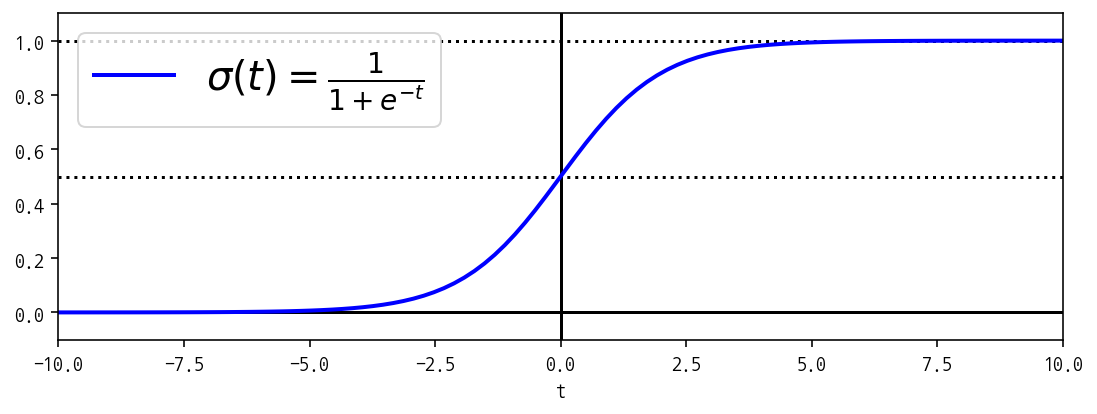

In [34]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

## 4.6.3 결정 경계

In [35]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [36]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(np.int)  # Iris virginica이면 1 아니면 0

In [37]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

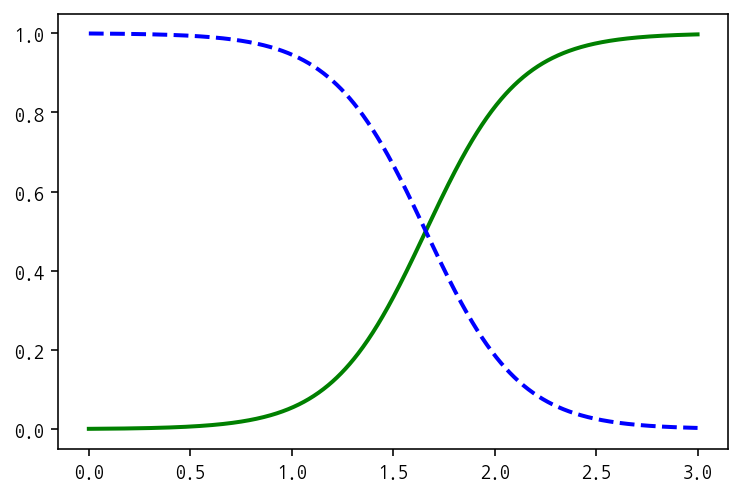

In [38]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

C:\Users\sarah\Anaconda3\lib\site-packages\matplotlib\patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


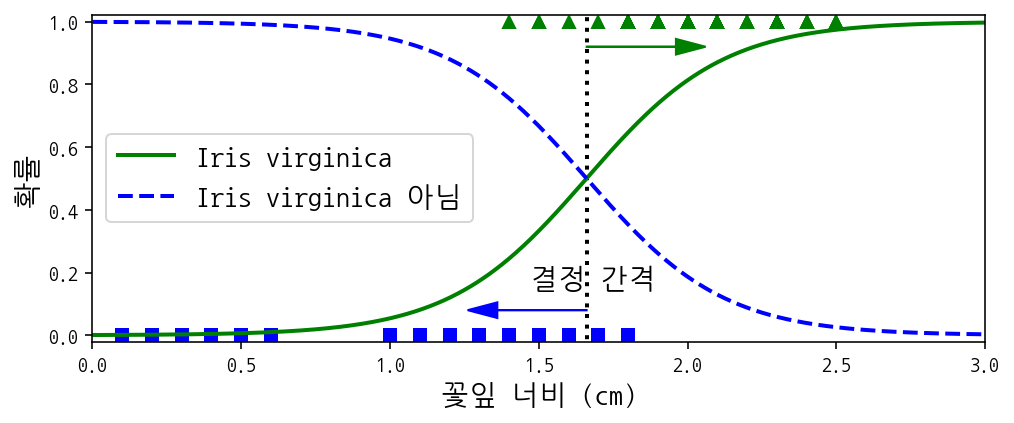

In [39]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Iris virginica 아님")
plt.text(decision_boundary+0.02, 0.15, "결정 간격", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("꽃잎 너비 (cm)", fontsize=14)
plt.ylabel("확률", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [40]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

## 4.6.4 소프트맥스 회귀

- 한 번에 하나의 클래스만 예측.
- 크로스 엔트로피(cross entropy) : 추정된 글래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도로 사용.

In [41]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [42]:
softmax_reg.predict([[5, 2]])

array([2])

In [43]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])